In [1]:
import sys
sys.path.insert(0, "../..")
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import matplotlib.pyplot as plt
import numpy
import spatialpy
print(spatialpy.__file__)

../../spatialpy/__init__.py


In [3]:
class Membrane(spatialpy.SubDomain):
    def __init__(self, radius_external, radius_internal):
        spatialpy.SubDomain.__init__(self)
        self.radius_external = radius_external
        self.radius_internal = radius_internal
        
    def inside(self, x, on_boundary):
        r = numpy.sqrt(x[0] * x[0] + x[1] * x[1])
        return self.radius_external >= r >= self.radius_internal
    
class Cytoplasm(spatialpy.SubDomain):
    def __init__(self, radius_external, radius_internal):
        spatialpy.SubDomain.__init__(self)
        self.radius_external = radius_external
        self.radius_internal = radius_internal
        
    def inside(self, x, on_boundary):
        r = numpy.sqrt(x[0] * x[0] + x[1] * x[1])
        return r < self.radius_internal
    
class GbgGradient(spatialpy.DataFunction):
    def __init__(self, Gbg_mid=5000, Gbg_slope=0.0, mem_vol=1.0):
        """ 1D domain from a to b. """
        spatialpy.DataFunction.__init__(self, name="GbgGradient")
        self.Gbg_mid = Gbg_mid
        self.Gbg_slope = Gbg_slope  # NM/um
        self.mem_vol = mem_vol
        
    def map(self, x):
        ret = self.Gbg_slope*x[2] + self.Gbg_mid
        return ret/self.mem_vol

In [4]:
def createfilled2ddomain(xlim, ylim, nx, ny):
        # Create mesh object
        numberparticles = nx*ny
        obj = spatialpy.Mesh(numberparticles)
        # Vertices
        obj.vertices = numpy.zeros(( int(nx)*int(ny), 3), dtype=float)
        x_list = numpy.linspace(xlim[0],xlim[1],nx)
        y_list = numpy.linspace(ylim[0],ylim[1],ny)
        ndx = 0
        totalvolume = (xlim[1] - xlim[0]) * (ylim[1] - ylim[0])
        for x in x_list:
            for y in y_list:
                obj.vol[ndx] = totalvolume / numberparticles
                obj.mass[ndx] = 1.0
                obj.vertices[ndx,0] = x        
                obj.vertices[ndx,1] = y
                obj.vertices[ndx,2] = 0.0
                ndx+=1
                
        # return model ref
        return obj

In [21]:
class Cdc42_cycle_2D_SpatialPy_SDPD(spatialpy.Model):

    def __init__(self, model_name="Cdc42_2D-Moving_Mesh",Gbg_conc=5000.0, Gbg_pct_slope=0.0,delta1_val=0.00297,delta1_gbg_val=0.00297,delta_neg_val=1.0/30000, end_time=None, mesh=None, msh_filename=None,mesh_id=None,rotate=None):
        spatialpy.Model.__init__(self,model_name)

        D_membrane = 0.0053   #diffusion on the membrane from PLOS paper
        D_GDP = 0.0053
        D_GTP = 0.0053
        D_bulk = 10.0#50.0          #not sure of bulk diffusion const
        
        # Species
        Cdc24_m= spatialpy.Species(name="Cdc24_m",  diffusion_constant=D_membrane)
        Cdc24_c= spatialpy.Species(name="Cdc24_c",  diffusion_constant=D_bulk)
        Cdc42= spatialpy.Species(name="Cdc42",  diffusion_constant=D_GDP)
        Cdc42_a= spatialpy.Species(name="Cdc42_a",  diffusion_constant=D_GTP)
        Bem1_m = spatialpy.Species(name="Bem1_m",  diffusion_constant=D_membrane)
        Bem1_c = spatialpy.Species(name="Bem1_c",  diffusion_constant=D_bulk)
        Cla4 = spatialpy.Species(name="Cla4",  diffusion_constant=D_bulk)
        Cla4_a = spatialpy.Species(name="Cla4_a",  diffusion_constant=D_membrane)
        Cdc42_c = spatialpy.Species(name="Cdc42_c",  diffusion_constant=D_bulk)
        self.add_species([Cdc24_m, Cdc24_c, Cdc42, Cdc42_a, Bem1_m, Bem1_c, Cla4, Cla4_a, Cdc42_c])#,Gbg])
        
        cell_radius = 2.0
        radius_external = 0.6
        radius_internal = 0.4

        self.mesh = createfilled2ddomain([-1,1], [-1,1], 80,80)

        self.add_subdomain(Membrane(radius_external, radius_internal), 2, mass=4.0)
        self.add_subdomain(Cytoplasm(radius_external, radius_internal), 3, mass=2.0)

        #self.mesh.get_vol()
        
        # Goto bitbucket repo and look for where the lmp file is defining vol. 
        # Modify get_vol in Mesh.py
        
        extra_cellular_volume = 0
        for voxel_index, voxel_coords in enumerate(self.mesh.coordinates()):
                if self.mesh.sd[voxel_index] == 1:
                    extra_cellular_volume = extra_cellular_volume + self.mesh.vol[voxel_index]
        membrane_volume = 0
        for voxel_index, voxel_coords in enumerate(self.mesh.coordinates()):
                if self.mesh.sd[voxel_index] == 2:
                    membrane_volume = membrane_volume + self.mesh.vol[voxel_index]
                    
        cytoplasm_volume = 0
        for voxel_index, voxel_coords in enumerate(self.mesh.coordinates()):
                if self.mesh.sd[voxel_index] == 3:
                    cytoplasm_volume = cytoplasm_volume + self.mesh.vol[voxel_index]
                    
        print("extra_cellular_volume",extra_cellular_volume)
        print("membrane_volume",membrane_volume)
        print("cytoplasm_volume",cytoplasm_volume)
        
        # Parameters
        k_42d =   spatialpy.Parameter(name="k_42d", expression=1.0)#0.02)
        k_42a =   spatialpy.Parameter(name="k_42a", expression=0.2)#ORIGINAL: 0.2 #INCREASE: 0.2*100.0 #1e-05*membrane_volume)#*SA)
        k_24cm1 = spatialpy.Parameter(name="k_24cm1", expression=delta1_val)#ORIGINAL: delta1_val #3.3e-03*cytoplasm_volume)#*V)
        k_24mc =  spatialpy.Parameter(name="k_24mc", expression=0.35) #ORIGINAL: 0.35 #1.0)
        k_B1mc =  spatialpy.Parameter(name="k_B1mc", expression=0.35)#0.01)
        k_B1cm =  spatialpy.Parameter(name="k_B1cm", expression=0.2667)#ORIGINAL: 0.2667 #1e-05*cytoplasm_volume)#*V)
        k_Cla4a = spatialpy.Parameter(name="k_Cla4a", expression=0.006)
        k_Cla4d = spatialpy.Parameter(name="k_Cla4d", expression=0.01)
        k_24d =   spatialpy.Parameter(name="k_24d", expression=delta_neg_val)#1/3000#membrane_volume#SA
        
        beta1 = spatialpy.Parameter(name="beta1", expression=0.266) #ORIGINAL: 0.266  #INCREASE: 0.266*100.0
        beta2 = spatialpy.Parameter(name="beta2", expression=0.28)
        beta3 = spatialpy.Parameter(name="beta3", expression=1.0) #*10.0 #ORIGINAL: 1.0 #INCREASE: 1.0*10.0
        delta1_gbg = spatialpy.Parameter(name="delta1_gbg", expression=delta1_gbg_val)
        self.add_parameter([k_42a, k_42d, k_24cm1, k_24mc, k_B1mc, k_B1cm, k_Cla4a, k_Cla4d, k_24d,beta1, beta2, beta3,delta1_gbg])

        # Add Data Function to model the mating pheromone gradient.
        self.add_data_function(GbgGradient(Gbg_mid=Gbg_conc,Gbg_slope=Gbg_conc*Gbg_pct_slope/(cell_radius*2.0),mem_vol=membrane_volume))

        # Reactions
        #Gbg as species
        #Gbg as input function
        #DIFFERENCE WHETHER TO MULTIPLY BY 32 OR NOT
        CR0 = spatialpy.Reaction(name="CR0", reactants={Cdc24_c:1}, products={Cdc24_m:1}, propensity_function="delta1_gbg*Cdc24_c*GbgGradient*vol", restrict_to=2)
        CR1 = spatialpy.Reaction(name="CR1", reactants={Cdc24_c:1,Bem1_m:1}, products={Cdc24_m:1,Bem1_m:1},  rate=k_24cm1, restrict_to=2)
        CR2 = spatialpy.Reaction(name="CR2", reactants={Cdc24_m:1}, products={Cdc24_c:1}, rate=k_24mc, restrict_to=2)
        CR3 = spatialpy.Reaction(name="CR3", reactants={Cdc24_m:1,Cla4_a:1}, products={Cdc24_c:1,Cla4_a:1}, rate=k_24d, restrict_to=2)
        CR4 = spatialpy.Reaction(name="CR4", reactants={Cdc24_m:1,Cdc42:1}, products={Cdc24_m:1,Cdc42_a:1}, rate=k_42a, restrict_to=2)
        CR5 = spatialpy.Reaction(name="CR5", reactants={Cdc42_a:1}, products={Cdc42:1}, rate=k_42d, restrict_to=2)
        CR6 = spatialpy.Reaction(name="CR6", reactants={Cdc42_a:1,Bem1_c:1}, products={Cdc42_a:1,Bem1_m:1}, rate=k_B1cm, restrict_to=2)
        CR7 = spatialpy.Reaction(name="CR7", reactants={Bem1_m:1}, products={Bem1_c:1}, rate=k_B1mc, restrict_to=2)
        CR8 = spatialpy.Reaction(name="CR8", reactants={Cdc42_a:1,Cla4:1}, products={Cdc42_a:1,Cla4_a:1}, rate=k_Cla4a, restrict_to=2)
        CR9 = spatialpy.Reaction(name="CR9", reactants={Cla4_a:1}, products={Cla4:1}, rate=k_Cla4d, restrict_to=2)
        
        CR10 = spatialpy.Reaction(name="CR10", reactants={Cdc42_c:1}, products={Cdc42:1}, rate=beta2, restrict_to=2)
        CR11 = spatialpy.Reaction(name="CR11", reactants={Cdc42:1}, products={Cdc42_c:1}, rate=beta3, restrict_to=2)
        CR12 = spatialpy.Reaction(name="CR12", reactants={Cdc42_c:1,Cdc24_m:1}, products={Cdc42_a:1,Cdc24_m:1}, rate=beta1, restrict_to=2)
        self.add_reaction([CR0,CR1,CR2,CR3,CR4,CR5,CR6,CR7,CR8,CR9,CR10,CR11,CR12])
        
        self.restrict(species=Cdc24_c,listOfSubDomains=[3,2])
        self.restrict(species=Bem1_c,listOfSubDomains=[3,2])
        self.restrict(species=Cla4,listOfSubDomains=[3,2])
        self.restrict(species=Cdc24_m,listOfSubDomains=[2])
        self.restrict(species=Cdc42,listOfSubDomains=[2])
        self.restrict(species=Cdc42_a,listOfSubDomains=[2])
        self.restrict(species=Bem1_m,listOfSubDomains=[2])
        self.restrict(species=Cla4_a,listOfSubDomains=[2])
        self.restrict(species=Cdc42_c,listOfSubDomains=[3,2])
        
        # Scatter initial condition
        self.add_initial_condition(spatialpy.ScatterInitialCondition(Cdc42,2700,[3])) # 10000  
        self.add_initial_condition(spatialpy.ScatterInitialCondition(Cdc24_c,1000,[2])) # We have 2000 Cdc24, GDI model has 1000
        self.add_initial_condition(spatialpy.ScatterInitialCondition(Bem1_c,3000,[2]))
        self.add_initial_condition(spatialpy.ScatterInitialCondition(Cla4,5000,[2]))  # 5000
        self.add_initial_condition(spatialpy.ScatterInitialCondition(Cdc42_a,300,[3]))

        if end_time is None:
            self.timespan(range(1000))
        else:
            if end_time >= 1.0:
                self.timespan(range(end_time))
            else:
                self.timespan(numpy.linspace(0,end_time,10))
            print("simulating to {0}s".format(end_time))

In [22]:
model = Cdc42_cycle_2D_SpatialPy_SDPD()

extra_cellular_volume 0
membrane_volume 0.6099999999999898
cytoplasm_volume 0.4924999999999923


In [10]:
result = model.run()

In [13]:
Cdc42_vals = result.get_species("Cdc42_a")

read_step(0) opening '/tmp/spatialpy_result_codx6kdk/output0.vtk'
read_step(1) opening '/tmp/spatialpy_result_codx6kdk/output1.vtk'
read_step(2) opening '/tmp/spatialpy_result_codx6kdk/output2.vtk'
read_step(3) opening '/tmp/spatialpy_result_codx6kdk/output3.vtk'
read_step(4) opening '/tmp/spatialpy_result_codx6kdk/output4.vtk'
read_step(5) opening '/tmp/spatialpy_result_codx6kdk/output5.vtk'
read_step(6) opening '/tmp/spatialpy_result_codx6kdk/output6.vtk'
read_step(7) opening '/tmp/spatialpy_result_codx6kdk/output7.vtk'
read_step(8) opening '/tmp/spatialpy_result_codx6kdk/output8.vtk'
read_step(9) opening '/tmp/spatialpy_result_codx6kdk/output9.vtk'
read_step(10) opening '/tmp/spatialpy_result_codx6kdk/output10.vtk'
read_step(11) opening '/tmp/spatialpy_result_codx6kdk/output11.vtk'
read_step(12) opening '/tmp/spatialpy_result_codx6kdk/output12.vtk'
read_step(13) opening '/tmp/spatialpy_result_codx6kdk/output13.vtk'
read_step(14) opening '/tmp/spatialpy_result_codx6kdk/output14.vtk'


read_step(124) opening '/tmp/spatialpy_result_codx6kdk/output124.vtk'
read_step(125) opening '/tmp/spatialpy_result_codx6kdk/output125.vtk'
read_step(126) opening '/tmp/spatialpy_result_codx6kdk/output126.vtk'
read_step(127) opening '/tmp/spatialpy_result_codx6kdk/output127.vtk'
read_step(128) opening '/tmp/spatialpy_result_codx6kdk/output128.vtk'
read_step(129) opening '/tmp/spatialpy_result_codx6kdk/output129.vtk'
read_step(130) opening '/tmp/spatialpy_result_codx6kdk/output130.vtk'
read_step(131) opening '/tmp/spatialpy_result_codx6kdk/output131.vtk'
read_step(132) opening '/tmp/spatialpy_result_codx6kdk/output132.vtk'
read_step(133) opening '/tmp/spatialpy_result_codx6kdk/output133.vtk'
read_step(134) opening '/tmp/spatialpy_result_codx6kdk/output134.vtk'
read_step(135) opening '/tmp/spatialpy_result_codx6kdk/output135.vtk'
read_step(136) opening '/tmp/spatialpy_result_codx6kdk/output136.vtk'
read_step(137) opening '/tmp/spatialpy_result_codx6kdk/output137.vtk'
read_step(138) openi

read_step(242) opening '/tmp/spatialpy_result_codx6kdk/output242.vtk'
read_step(243) opening '/tmp/spatialpy_result_codx6kdk/output243.vtk'
read_step(244) opening '/tmp/spatialpy_result_codx6kdk/output244.vtk'
read_step(245) opening '/tmp/spatialpy_result_codx6kdk/output245.vtk'
read_step(246) opening '/tmp/spatialpy_result_codx6kdk/output246.vtk'
read_step(247) opening '/tmp/spatialpy_result_codx6kdk/output247.vtk'
read_step(248) opening '/tmp/spatialpy_result_codx6kdk/output248.vtk'
read_step(249) opening '/tmp/spatialpy_result_codx6kdk/output249.vtk'
read_step(250) opening '/tmp/spatialpy_result_codx6kdk/output250.vtk'
read_step(251) opening '/tmp/spatialpy_result_codx6kdk/output251.vtk'
read_step(252) opening '/tmp/spatialpy_result_codx6kdk/output252.vtk'
read_step(253) opening '/tmp/spatialpy_result_codx6kdk/output253.vtk'
read_step(254) opening '/tmp/spatialpy_result_codx6kdk/output254.vtk'
read_step(255) opening '/tmp/spatialpy_result_codx6kdk/output255.vtk'
read_step(256) openi

read_step(360) opening '/tmp/spatialpy_result_codx6kdk/output360.vtk'
read_step(361) opening '/tmp/spatialpy_result_codx6kdk/output361.vtk'
read_step(362) opening '/tmp/spatialpy_result_codx6kdk/output362.vtk'
read_step(363) opening '/tmp/spatialpy_result_codx6kdk/output363.vtk'
read_step(364) opening '/tmp/spatialpy_result_codx6kdk/output364.vtk'
read_step(365) opening '/tmp/spatialpy_result_codx6kdk/output365.vtk'
read_step(366) opening '/tmp/spatialpy_result_codx6kdk/output366.vtk'
read_step(367) opening '/tmp/spatialpy_result_codx6kdk/output367.vtk'
read_step(368) opening '/tmp/spatialpy_result_codx6kdk/output368.vtk'
read_step(369) opening '/tmp/spatialpy_result_codx6kdk/output369.vtk'
read_step(370) opening '/tmp/spatialpy_result_codx6kdk/output370.vtk'
read_step(371) opening '/tmp/spatialpy_result_codx6kdk/output371.vtk'
read_step(372) opening '/tmp/spatialpy_result_codx6kdk/output372.vtk'
read_step(373) opening '/tmp/spatialpy_result_codx6kdk/output373.vtk'
read_step(374) openi

read_step(481) opening '/tmp/spatialpy_result_codx6kdk/output481.vtk'
read_step(482) opening '/tmp/spatialpy_result_codx6kdk/output482.vtk'
read_step(483) opening '/tmp/spatialpy_result_codx6kdk/output483.vtk'
read_step(484) opening '/tmp/spatialpy_result_codx6kdk/output484.vtk'
read_step(485) opening '/tmp/spatialpy_result_codx6kdk/output485.vtk'
read_step(486) opening '/tmp/spatialpy_result_codx6kdk/output486.vtk'
read_step(487) opening '/tmp/spatialpy_result_codx6kdk/output487.vtk'
read_step(488) opening '/tmp/spatialpy_result_codx6kdk/output488.vtk'
read_step(489) opening '/tmp/spatialpy_result_codx6kdk/output489.vtk'
read_step(490) opening '/tmp/spatialpy_result_codx6kdk/output490.vtk'
read_step(491) opening '/tmp/spatialpy_result_codx6kdk/output491.vtk'
read_step(492) opening '/tmp/spatialpy_result_codx6kdk/output492.vtk'
read_step(493) opening '/tmp/spatialpy_result_codx6kdk/output493.vtk'
read_step(494) opening '/tmp/spatialpy_result_codx6kdk/output494.vtk'
read_step(495) openi

read_step(606) opening '/tmp/spatialpy_result_codx6kdk/output606.vtk'
read_step(607) opening '/tmp/spatialpy_result_codx6kdk/output607.vtk'
read_step(608) opening '/tmp/spatialpy_result_codx6kdk/output608.vtk'
read_step(609) opening '/tmp/spatialpy_result_codx6kdk/output609.vtk'
read_step(610) opening '/tmp/spatialpy_result_codx6kdk/output610.vtk'
read_step(611) opening '/tmp/spatialpy_result_codx6kdk/output611.vtk'
read_step(612) opening '/tmp/spatialpy_result_codx6kdk/output612.vtk'
read_step(613) opening '/tmp/spatialpy_result_codx6kdk/output613.vtk'
read_step(614) opening '/tmp/spatialpy_result_codx6kdk/output614.vtk'
read_step(615) opening '/tmp/spatialpy_result_codx6kdk/output615.vtk'
read_step(616) opening '/tmp/spatialpy_result_codx6kdk/output616.vtk'
read_step(617) opening '/tmp/spatialpy_result_codx6kdk/output617.vtk'
read_step(618) opening '/tmp/spatialpy_result_codx6kdk/output618.vtk'
read_step(619) opening '/tmp/spatialpy_result_codx6kdk/output619.vtk'
read_step(620) openi

read_step(727) opening '/tmp/spatialpy_result_codx6kdk/output727.vtk'
read_step(728) opening '/tmp/spatialpy_result_codx6kdk/output728.vtk'
read_step(729) opening '/tmp/spatialpy_result_codx6kdk/output729.vtk'
read_step(730) opening '/tmp/spatialpy_result_codx6kdk/output730.vtk'
read_step(731) opening '/tmp/spatialpy_result_codx6kdk/output731.vtk'
read_step(732) opening '/tmp/spatialpy_result_codx6kdk/output732.vtk'
read_step(733) opening '/tmp/spatialpy_result_codx6kdk/output733.vtk'
read_step(734) opening '/tmp/spatialpy_result_codx6kdk/output734.vtk'
read_step(735) opening '/tmp/spatialpy_result_codx6kdk/output735.vtk'
read_step(736) opening '/tmp/spatialpy_result_codx6kdk/output736.vtk'
read_step(737) opening '/tmp/spatialpy_result_codx6kdk/output737.vtk'
read_step(738) opening '/tmp/spatialpy_result_codx6kdk/output738.vtk'
read_step(739) opening '/tmp/spatialpy_result_codx6kdk/output739.vtk'
read_step(740) opening '/tmp/spatialpy_result_codx6kdk/output740.vtk'
read_step(741) openi

read_step(848) opening '/tmp/spatialpy_result_codx6kdk/output848.vtk'
read_step(849) opening '/tmp/spatialpy_result_codx6kdk/output849.vtk'
read_step(850) opening '/tmp/spatialpy_result_codx6kdk/output850.vtk'
read_step(851) opening '/tmp/spatialpy_result_codx6kdk/output851.vtk'
read_step(852) opening '/tmp/spatialpy_result_codx6kdk/output852.vtk'
read_step(853) opening '/tmp/spatialpy_result_codx6kdk/output853.vtk'
read_step(854) opening '/tmp/spatialpy_result_codx6kdk/output854.vtk'
read_step(855) opening '/tmp/spatialpy_result_codx6kdk/output855.vtk'
read_step(856) opening '/tmp/spatialpy_result_codx6kdk/output856.vtk'
read_step(857) opening '/tmp/spatialpy_result_codx6kdk/output857.vtk'
read_step(858) opening '/tmp/spatialpy_result_codx6kdk/output858.vtk'
read_step(859) opening '/tmp/spatialpy_result_codx6kdk/output859.vtk'
read_step(860) opening '/tmp/spatialpy_result_codx6kdk/output860.vtk'
read_step(861) opening '/tmp/spatialpy_result_codx6kdk/output861.vtk'
read_step(862) openi

read_step(969) opening '/tmp/spatialpy_result_codx6kdk/output969.vtk'
read_step(970) opening '/tmp/spatialpy_result_codx6kdk/output970.vtk'
read_step(971) opening '/tmp/spatialpy_result_codx6kdk/output971.vtk'
read_step(972) opening '/tmp/spatialpy_result_codx6kdk/output972.vtk'
read_step(973) opening '/tmp/spatialpy_result_codx6kdk/output973.vtk'
read_step(974) opening '/tmp/spatialpy_result_codx6kdk/output974.vtk'
read_step(975) opening '/tmp/spatialpy_result_codx6kdk/output975.vtk'
read_step(976) opening '/tmp/spatialpy_result_codx6kdk/output976.vtk'
read_step(977) opening '/tmp/spatialpy_result_codx6kdk/output977.vtk'
read_step(978) opening '/tmp/spatialpy_result_codx6kdk/output978.vtk'
read_step(979) opening '/tmp/spatialpy_result_codx6kdk/output979.vtk'
read_step(980) opening '/tmp/spatialpy_result_codx6kdk/output980.vtk'
read_step(981) opening '/tmp/spatialpy_result_codx6kdk/output981.vtk'
read_step(982) opening '/tmp/spatialpy_result_codx6kdk/output982.vtk'
read_step(983) openi

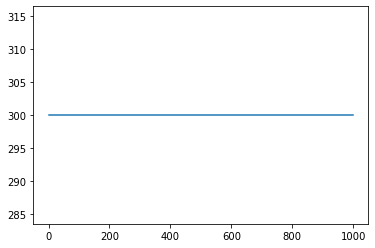

In [20]:
plt.plot(result.get_timespan(), Cdc42_vals.sum(axis=1))

In [25]:
result.display("Cdc42_a",0)

Exception: TODO

In [31]:
type_vals = result.get_property("type",0)

read_step(0) opening '/tmp/spatialpy_result_codx6kdk/output0.vtk'


In [32]:
type_vals

array([0., 0., 0., ..., 0., 0., 0.])